In [155]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn import metrics

In [215]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df = pd.concat([train, test])

datetime = []
for i, row in df.iterrows():
    datetime.append(row['Date'] + ' ' + row['Time'])
    
df['Datetime'] = pd.to_datetime(datetime, dayfirst=True)
df = df.drop(columns = ['Date', 'Time'])

Td = df.iloc[len(train)]['Datetime'] - df.iloc[len(train)-1]['Datetime'] - pd.Timedelta(15, "m")
df.iloc[len(train):, -1] = df.iloc[len(train):, -1] - Td

In [216]:
df['hour'] = df['Datetime'].dt.hour
df['Day_of_month'] = df['Datetime'].dt.days_in_month

<Axes: xlabel='Datetime'>

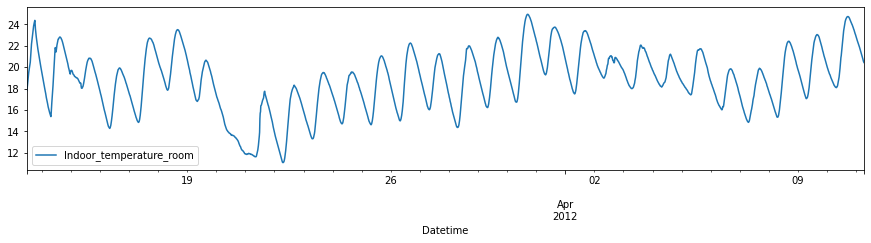

In [217]:
df[:len(train)].plot(y='Indoor_temperature_room', x='Datetime', figsize = (15, 3))

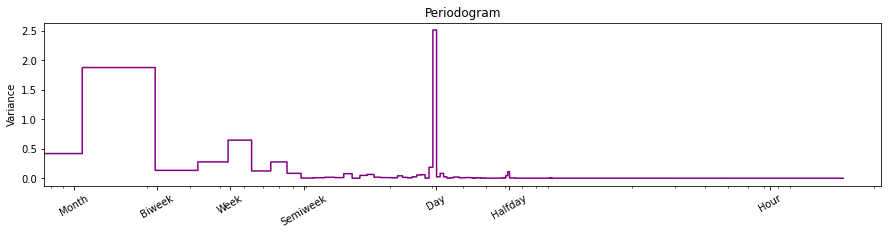

In [218]:
freqencies, spectrum = periodogram(
        df[:len(train)]['Indoor_temperature_room'],
        fs=2976,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2.2, 4.4, 8.85, 31, 62, 744],
          [
        "Month",
        "Biweek",
        "Week",
        "Semiweek",
        "Day",
        "Halfday",
        "Hour"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [219]:
dates = df['Datetime'].unique()
hours = np.arange(1, len(dates)+1)
hours = pd.DataFrame({"Datetime":dates, "Hour_tick":hours})
df = df.merge(hours, on="Datetime", how="left")

In [220]:
Seasonality = dict(zip(
    (96, 336, 672, 1344, 2976),
    ('Day', 'Semiweek', 'Week', 'Biweek', 'Month')
))

for s, n in Seasonality.items():
    df[f'sin_{n}'] = np.sin(df['Hour_tick'] * (2*np.pi / s))
    df[f'cos_{n}'] = np.cos(df['Hour_tick'] * (2*np.pi / s))

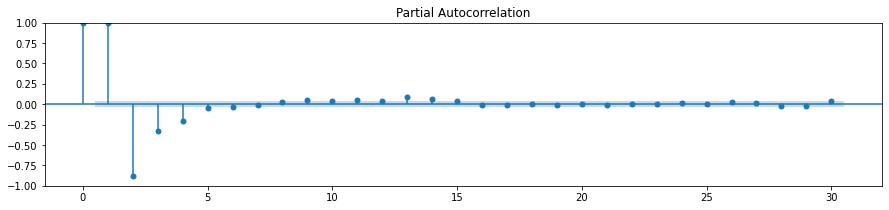

In [221]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(df[:len(train)]['Indoor_temperature_room'], lags=30, ax=ax)
plt.show()

In [222]:
lags = [1, 2, 3, 4]
for lag in lags:                                                                                                                          
    df[f'lag_{lag}'] = df['Indoor_temperature_room'].shift(lag)

In [223]:
nan_head = df[df['Datetime'] == df['Datetime'][0] + pd.Timedelta(lags[-1]*15, "m")].index[0]
df = df[nan_head:].set_index('Datetime')

In [252]:
X_train = df.dropna().drop(columns = ['Indoor_temperature_room'])
y_train = df.dropna()['Indoor_temperature_room']

model = Ridge()
model.fit(X_train, y_train)

training_error = metrics.mean_squared_error(y_train, model.predict(X_train))

In [253]:
forecast = df.copy()

forecast_date_range = forecast[forecast['Indoor_temperature_room'].isna()].index
    
for i in (range(len(forecast[forecast['Indoor_temperature_room'].isna()].index))):
    
    future_index = forecast[forecast['Indoor_temperature_room'].isna()].index[0]
    future_X = forecast.loc[future_index:future_index].drop(columns = ['Indoor_temperature_room'])

    try:
        future_1 = model.predict(future_X)[0]
    except:
        pass

    try:
        forecast.loc[future_index, 'Indoor_temperature_room'] = future_1
        for lag in lags:
            forecast.loc[future_index + pd.Timedelta(lag*15, "m"), f'lag_{lag}'] = future_1

    except Exception as e:
        pass

forecast = forecast.loc[forecast_date_range[0]:forecast_date_range[-1]]
#test_error = metrics.mean_squared_error(test['Indoor_temperature_room'], forecast['Indoor_temperature_room'])

print("Training error: ", training_error)
#print("Test error: ", test_error)

Training error:  0.001943633295989565


<Axes: xlabel='Datetime'>

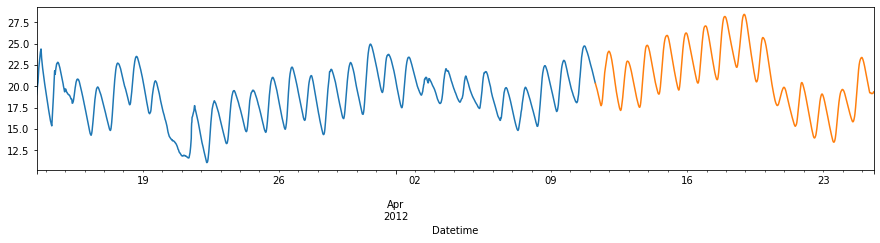

In [254]:
ax = df['Indoor_temperature_room'][:len(train)].plot(figsize = (15, 3))
forecast['Indoor_temperature_room'].plot(ax = ax)

In [250]:
output = forecast[['Id', 'Indoor_temperature_room']].sort_values(by = "Id")
output['Id'] = output['Id'].astype(int)

In [251]:
output.to_csv("submission_xgb.csv", index = False)